In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from string import punctuation 
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
test=pd.read_csv("D:\\senti\\test.csv",encoding='latin1')
train=pd.read_csv("D:\\senti\\train.csv",encoding='latin1')

In [3]:
df=pd.concat([test,train])
df.isnull().sum()

textID              1281
text                1282
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
selected_text       4816
dtype: int64

In [4]:
df.dropna(inplace=True)
df.isnull().sum()

textID              0
text                0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
selected_text       0
dtype: int64

In [5]:
def remove_unnecessary_characters(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text
df['clean_text'] = df['text'].apply(remove_unnecessary_characters)


In [6]:
def tokenize_text(text):
    try:
        text = str(text)
        tokens = word_tokenize(text)
        return tokens
    except Exception as e:
        print(f"Error tokenizing text: {e}")
        return []
df['tokens'] = df['text'].apply(tokenize_text)

In [7]:
def normalize_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = str(text)
    return text
df['normalized_text'] = df['text'].apply(normalize_text)
df['normalized_text'].head()

0                    id have responded if i were going
1           sooo sad i will miss you here in san diego
2                               my boss is bullying me
3                        what interview leave me alone
4    sons of why couldnt they put them on the relea...
Name: normalized_text, dtype: object

In [8]:
def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()        
        filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
        filtered_text = ' '.join(filtered_words)
    else:
        filtered_text = ''
    return filtered_text
df['text_without_stopwords'] = df['text'].apply(remove_stopwords)

In [9]:
df.dropna(inplace=True)

In [10]:
df.columns

Index(['textID', 'text', 'sentiment', 'Time of Tweet', 'Age of User',
       'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)',
       'selected_text', 'clean_text', 'tokens', 'normalized_text',
       'text_without_stopwords'],
      dtype='object')

0         neutral
1        negative
2        negative
3        negative
4        negative
           ...   
27476    negative
27477    negative
27478    positive
27479    positive
27480     neutral
Name: sentiment, Length: 27480, dtype: object

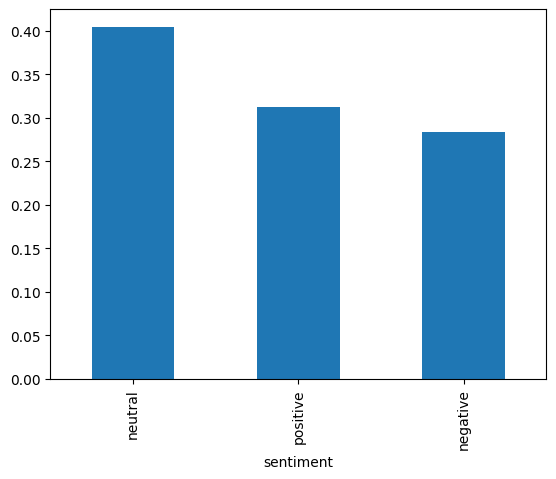

In [11]:
df['sentiment'].value_counts(normalize=True).plot(kind='bar');
df['sentiment']

In [12]:
df['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

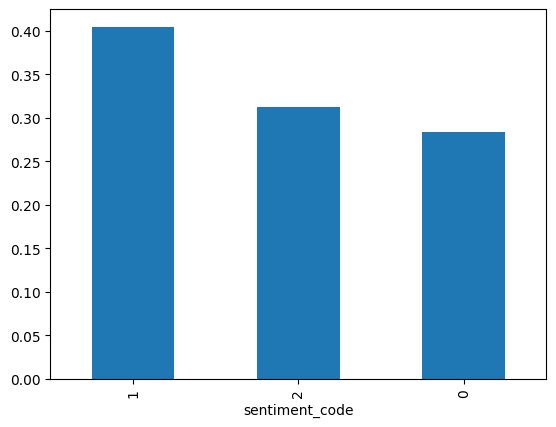

In [13]:
df['sentiment_code'] = df['sentiment'].astype('category').cat.codes
sentiment_distribution = df['sentiment_code'].value_counts(normalize=True)
sentiment_distribution.plot(kind='bar')
plt.show()

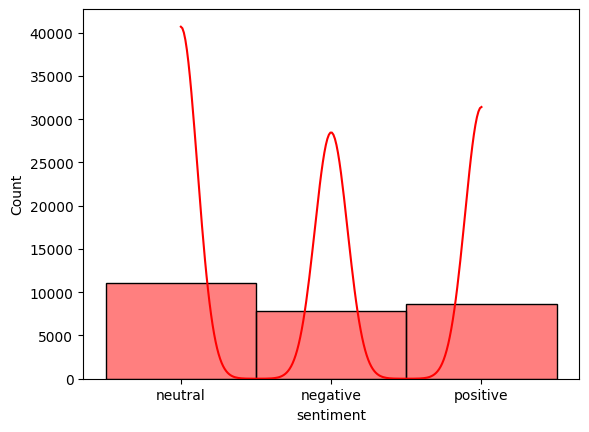

In [14]:
sns.histplot(df['sentiment'], kde=True, color = 'r')
plt.show()

In [15]:
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()
corpus = df['text'].tolist()
print(len(corpus))
print(corpus[0])

27480
 I`d have responded, if I were going


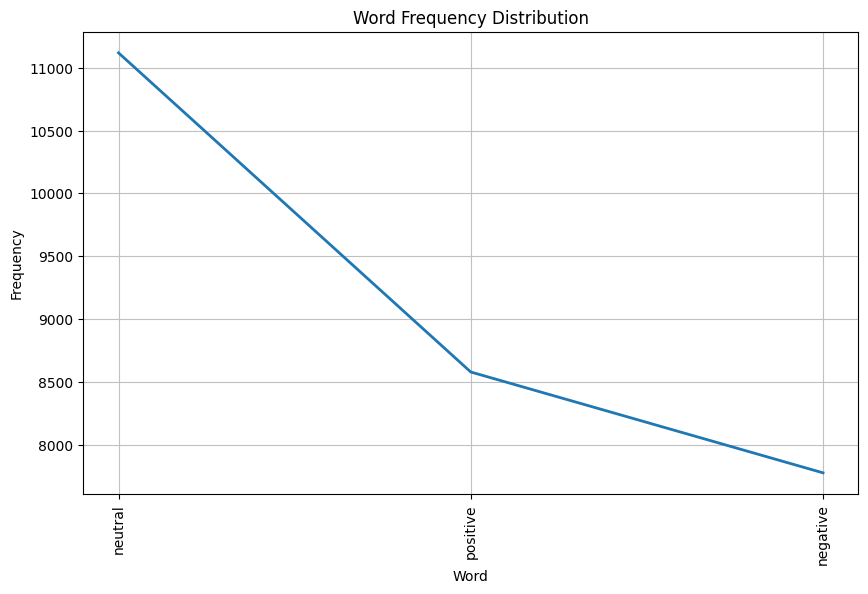

In [16]:
from nltk.probability import FreqDist
word_freq = FreqDist(word_tokenize(' '.join(df['sentiment'])))
plt.figure(figsize=(10, 6))
word_freq.plot(20, cumulative=False)
plt.title('Word Frequency Distribution')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

In [17]:
final_corpus = df['text'].astype(str).tolist()
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = df["sentiment"].values
data_eda.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [18]:
df['Time of Tweet'] = df['Time of Tweet'].astype('category').cat.codes
df['Country'] = df['Country'].astype('category').cat.codes
df['Age of User']=df['Age of User'].replace({'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80})

In [19]:
df=df.drop(columns=['textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

In [20]:
import string
def wp(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['selected_text'] = df["selected_text"].apply(wp)

In [21]:
X=df['selected_text']
y= df['sentiment']

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
XV_train = vectorization.fit_transform(X_train)
XV_test = vectorization.transform(X_test)

In [24]:
score_baseline = df['sentiment'].value_counts(normalize=True).max()
score_baseline

np.float64(0.40454876273653567)

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(n_jobs=-1)
lr.fit(XV_train,y_train)

LogisticRegression(n_jobs=-1)

In [26]:
pred_lr=lr.predict(XV_test)

In [27]:
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
score_lr = accuracy_score(y_test, pred_lr)
score_lr

0.8347889374090247

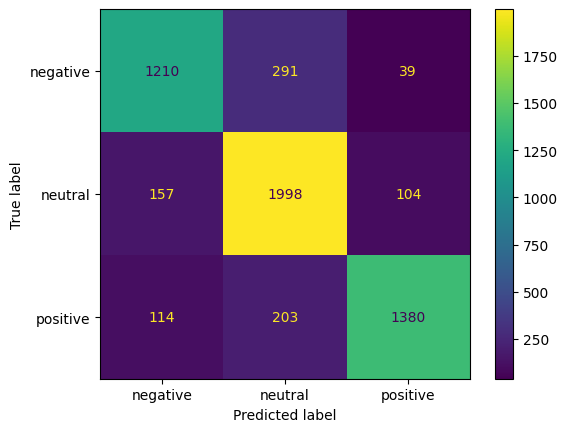

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr)

In [29]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(XV_train, y_train)

DecisionTreeClassifier()

In [30]:
pred_dt = dt.predict(XV_test)

In [31]:
score_dt = dt.score(XV_test, y_test)
score_dt

0.7554585152838428

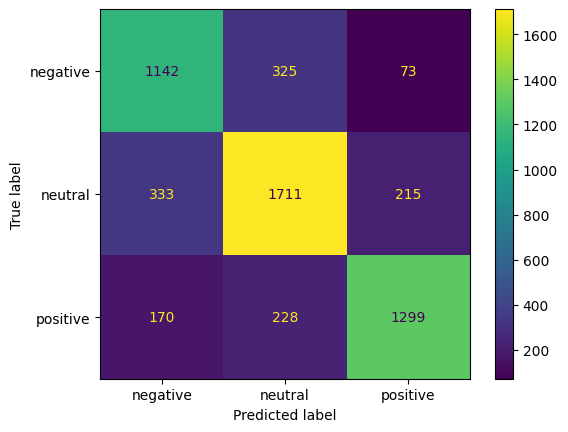

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_dt)

In [33]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)
rfc.fit(XV_train, y_train)

RandomForestClassifier(random_state=0)

In [34]:
pred_rfc = rfc.predict(XV_test)

In [35]:
score_rfc = rfc.score(XV_test, y_test)
score_rfc

0.8218704512372634

In [36]:
print(classification_report(y_test, pred_rfc))


              precision    recall  f1-score   support

    negative       0.79      0.76      0.77      1540
     neutral       0.78      0.90      0.84      2259
    positive       0.94      0.77      0.85      1697

    accuracy                           0.82      5496
   macro avg       0.83      0.81      0.82      5496
weighted avg       0.83      0.82      0.82      5496



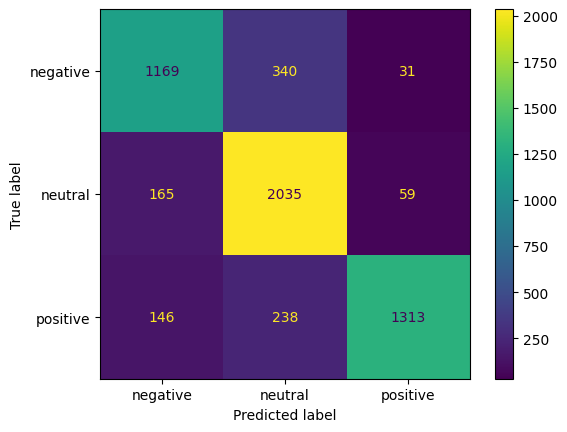

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_rfc)

In [38]:
print(f'Baseline model:{score_baseline} \nLogistic regression {score_lr}\nDecision Tree Classification {score_dt}\nRandim Forest Classifier {score_rfc}')

Baseline model:0.40454876273653567 
Logistic regression 0.8347889374090247
Decision Tree Classification 0.7554585152838428
Randim Forest Classifier 0.8218704512372634


In [39]:
def output_lable(n):
    if n == 0:
        return "The Text Sentement is Negative"
    elif n == 1:
        return "The Text Sentement is Neutral"
    elif n == 2:
        return "The Text Sentement is Positive"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wp) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_lr = lr.predict(new_xv_test)
    pred_dt = dt.predict(new_xv_test)
    pred_rfc = rfc.predict(new_xv_test)

    return print((output_lable(pred_lr[1])))

In [40]:
def wp(text):
    return text.upper()
def manual_testing(news):
    testing_news = {"text": [news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wp) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    return new_xv_test
text = "i am very happy"
print(manual_testing(text))

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 15318)>
  Coords	Values
  (0, 408)	0.5835346931691643
  (0, 5908)	0.5030478454875872
  (0, 14244)	0.6375187267980963
